# Data Aquisition and Exporatory Data Analysis (EDA)
**Group:** *Justin Williams / Jacob Silver / Gregg Maloy*<br>

This notebook will utilize the **Yelp Fusion API** to call businesses and their respective reviews from predefined zip codes within NYC and do some EDA

In [1]:
# import packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import sys
sys.path.append('src') # add src folder to path

# import api key
from config import YELP_API

Set up headers for API Call.

In [3]:
# Set up headers and access token
headers = {
    "Authorization": f"Bearer {YELP_API}",
    "Content-Type": "application/json"
}

# Set the locations to search for businesses
locations = [
    "Brooklyn","Queens","Bronx","Richmond","New York"
]

Next we perform the business querys.<br>
We have a **one-to-many relationship**, with businesses to reviews, so we will need to query the businesses first, than use those business ids to query the reviews.<br>
In addition, there is a <=50 businesses and a limit of 3 reviews per query, so we will need to offset businesses to query the desired amount<br>
Let's loop through each location to apply the query.

In [4]:
# Set the number of businesses and reviews to fetch per location
desired_businesses_per_location = 150
desired_reviews_per_business = 3

# Data storage lists
business_data = []
review_data = []

for location in locations:
    # Fetch businesses
    offset = 0
    businesses_fetched = 0
    while businesses_fetched < desired_businesses_per_location:
        # Query for the businesses in the current location with offset and limit
        businesses_url = "https://api.yelp.com/v3/businesses/search"
        params = {
            "location": location,
            "categories": "restaurant",
            "limit": min(desired_businesses_per_location - businesses_fetched, 50),
            "offset": offset
        }

        # API call to fetch businesses
        response = requests.get(businesses_url, params=params, headers=headers)
        data = response.json()

        # Extract info
        businesses = data["businesses"]

        if not businesses:
            # No more businesses found for the current location, break the loop
            break

        # Iterate over the businesses and fetch their reviews
        for business in businesses:
            business_id = business["id"]

            # Query for the reviews of the current business
            reviews_url = f"https://api.yelp.com/v3/businesses/{business_id}/reviews"
            reviews_params = {
                "limit": desired_reviews_per_business,
                "offset": 0
            }

            # API call to fetch reviews
            reviews_response = requests.get(reviews_url, params=reviews_params, headers=headers)
            reviews_data = reviews_response.json()

            # Extract info
            reviews = reviews_data["reviews"]

            # Store business data
            business_data.append({
                "business_id": business_id,
                "name": business["name"],
                "address1": business["location"]["address1"],
                "address2": business["location"].get("address2", ""),
                "city": business["location"]["city"],
                "postal_code": business["location"]["zip_code"],
                "rating": business["rating"],
                "review_count": business["review_count"],
                "is_closed": business["is_closed"],
                "latitude": business["coordinates"]["latitude"],
                "longitude": business["coordinates"]["longitude"]
            })

            # Store review data
            for review in reviews:
                review_data.append({
                    "business_id": business_id,
                    "review_user_id": review["user"]["id"],
                    "review_user": review["user"]["name"],
                    "review_rating": review["rating"],
                    "review_text": review["text"]
                })

            businesses_fetched += 1

            # Check if we have reached the desired total businesses
            if businesses_fetched >= desired_businesses_per_location:
                break

        offset += 50

        # Check if we have reached the desired total businesses
        if businesses_fetched >= desired_businesses_per_location:
            break


Create two dataframes:
- one for businesses
- one for reviews

Having separate dataframes will allow us to explore the **one-to-many** relationship between business and reviews.

In [20]:

# Create dataframes
business_df = pd.DataFrame(business_data)
review_df = pd.DataFrame(review_data)

## Business dataframe EDA
Let's look at the datatypes and preview.

In [9]:
# preview
business_df.head()

,business_id,name,address1,address2,city,postal_code,rating,review_count,is_cloused,latitude,longitude
0,AHB-e8F_dipajUaz_PJgDA,Krupa Grocery,231 Prospect Park W,,Brooklyn,11215,4.5,390,False,40.659824,-73.980508
1,TQzGf4k3HXyMbnNkYKKQSw,Oxalis,791 Washington Ave,None,Brooklyn,11238,4.5,242,False,40.673109,-73.962628
2,FXBrt0VpeBRengdd4fBOZw,Werkstatt,509 Coney Island Ave,,Brooklyn,11218,4.5,314,False,40.645298,-73.970234
3,_zRVdCfUcx1cwseFycSQdQ,Thai Farm Kitchen,416 Church Ave,,Brooklyn,11218,4.5,348,False,40.644042,-73.976052
4,C8j0q4Ma_S5hBGuAI-aaww,Di Fara Pizza,1424 Ave J,,Brooklyn,11230,4.0,3987,False,40.625093,-73.961531


In [10]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 749
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   647 non-null    object 
 1   name          647 non-null    object 
 2   address1      647 non-null    object 
 3   address2      474 non-null    object 
 4   city          647 non-null    object 
 5   postal_code   647 non-null    object 
 6   rating        647 non-null    float64
 7   review_count  647 non-null    int64  
 8   is_cloused    647 non-null    bool   
 9   latitude      647 non-null    float64
 10  longitude     647 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 56.2+ KB


Ok, so we have 11 columns here and 750 businesses.<br>
Let's drop any duplicates to ensure we have all unique businesses.

In [11]:
business_df.drop_duplicates(inplace=True)

In [12]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 749
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   647 non-null    object 
 1   name          647 non-null    object 
 2   address1      647 non-null    object 
 3   address2      474 non-null    object 
 4   city          647 non-null    object 
 5   postal_code   647 non-null    object 
 6   rating        647 non-null    float64
 7   review_count  647 non-null    int64  
 8   is_cloused    647 non-null    bool   
 9   latitude      647 non-null    float64
 10  longitude     647 non-null    float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 56.2+ KB


Ok, now we have 647 unique businesses.<br>
We made our query for 150 businesses from each boro in NYC, let's see their distribution by city top 10.

In [20]:
pd.DataFrame(business_df.groupby('city').size().sort_values(ascending=False).head(10)).\
  reset_index().rename(columns={0:"count"})

,city,count
0,New York,161
1,Richmond,150
2,Brooklyn,138
3,Bronx,46
4,Astoria,35
5,Flushing,29
6,Forest Hills,18
7,Long Island City,11
8,Elmhurst,8
9,Bayside,7


Looks like the businesses are mostly from `New York` (which is Manhattan) and `Richmond` (Staten Island), followed by `Brooklyn` and the `Bronx`. However, Queens is the only county that breaks its areas up into "towns" per say, so we can see those aggregated after the first 4. 

Let's also take a look at review count, to get an idea of how reviewed the top 10 businesses area.

In [26]:
pd.DataFrame(business_df.groupby('name').agg({'review_count':'sum','city':'first'})\
  .sort_values(by='review_count',ascending=False).head(10)).reset_index()\
    .rename(columns={0:"count"})

,name,review_count,city
0,Peter Luger,6811,Brooklyn
1,LoveMama,6480,New York
2,Prince Street Pizza,4967,New York
3,Olio e Più,4599,New York
4,Buddakan,4525,New York
5,Di Fara Pizza,3987,Brooklyn
6,Beauty & Essex,3849,New York City
7,Cafe Mogador,3526,Brooklyn
8,Dinosaur Bar-B-Que,3468,New York
9,The Metropolitan Museum of Art,3414,New York


Looks like `Peter Luger` in Brooklyn is the most reviewed restaurant in the group, followed by `LoveMama` and `Prince Sreet Pizza`. Odd to see the `MOMA` as a top reviewed restaurant in NYC, however I think thats the only one of these I have actually been too.

Let's take a look at the average rating and distribution of this score, since this is what we will be using text modeling to predict.

In [15]:
round(business_df['rating'].mean(),2)

4.27

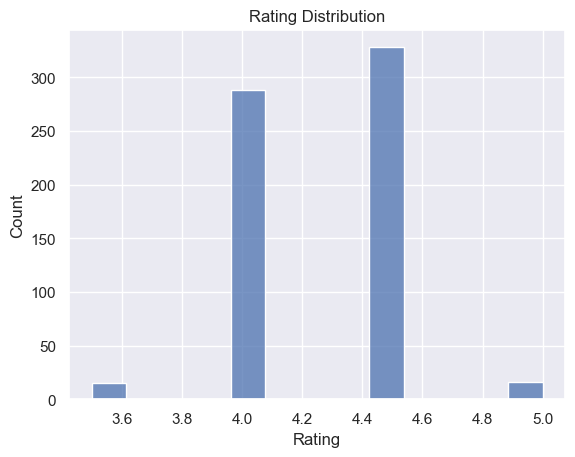

In [25]:
sns.set_style("darkgrid")
sns.set_theme("notebook")
sns.histplot(data=business_df,
             x='rating')
plt.xlabel("Rating")
plt.title("Rating Distribution")
plt.savefig("./img/hist_biz.png")
plt.show()

Ok, we can see that the average rating is ~4.27, and the largest distribution is 4.5.
It looks like they can only enter ratings in 0.5 increments, hence the discrete distribution.
Looks like ratings at the extremes are also more scarce.

Let's just see if `review_count` goes up, does that have any correlation with `rating`.

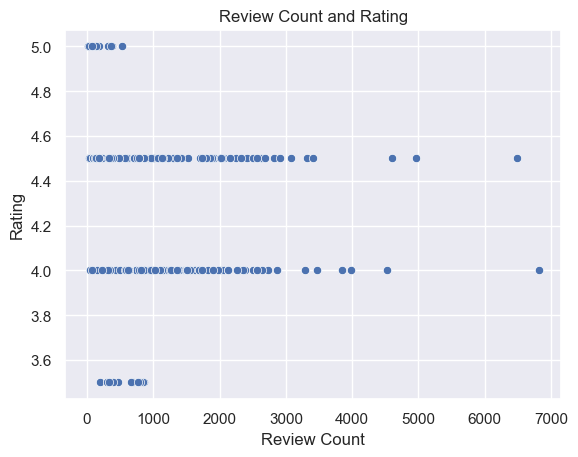

In [26]:
sns.scatterplot(data=business_df,
                x='review_count',
                y='rating')
plt.xlabel("Review Count")
plt.ylabel("Rating")
plt.title("Review Count and Rating")
plt.savefig("./img/scatter_biz.png")
plt.show()

Alright, so looks like most of the businesses with a large amount of `review_count`, have `rating` typically between 4 and 4.5, whereas those with fewer reviews sit very high, or lower than average.

Let's check out the `reviews_df`.

## Review dataframe EDA

Let's preview and look at some dtypes.

In [29]:
# preview
reviews_df.head()

,business_id,review_user_id,review_user,review_rating,review_text
0,AHB-e8F_dipajUaz_PJgDA,fGa2U9PDK2S32LcGsJNAyQ,Carol S.,5,Wow!! Krupa Grocery is an awesome brunch spot ...
1,AHB-e8F_dipajUaz_PJgDA,RbwbMvXJ0_ZY1WmaaYKMrA,Nicole D.,5,The service was great. We got the barata as an...
2,AHB-e8F_dipajUaz_PJgDA,8302qBEmZeTJZQY72xD4Sg,Lina F.,4,I love this place! It is my home away from hom...
3,TQzGf4k3HXyMbnNkYKKQSw,jNKKoDWxBcSFRYNvA2hqBA,Maggie B.,5,I celebrated my partner's birthday here and it...
4,TQzGf4k3HXyMbnNkYKKQSw,CWtnLR7fF5jVukm5BvOzIg,Veronica J.,5,"If you want sublime dinner experience, Oxalis ..."


In [31]:
# dtypes
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 2249
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   business_id     1941 non-null   object
 1   review_user_id  1941 non-null   object
 2   review_user     1941 non-null   object
 3   review_rating   1941 non-null   int64 
 4   review_text     1941 non-null   object
dtypes: int64(1), object(4)
memory usage: 91.0+ KB


Ok, so we have 2250 revies and 5 columns.<br>
Let's drop any duplicated columns.

In [32]:
reviews_df.drop_duplicates(inplace=True)

In [33]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1941 entries, 0 to 2249
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   business_id     1941 non-null   object
 1   review_user_id  1941 non-null   object
 2   review_user     1941 non-null   object
 3   review_rating   1941 non-null   int64 
 4   review_text     1941 non-null   object
dtypes: int64(1), object(4)
memory usage: 91.0+ KB


Ok, now we have 1941 rows.<br>
Because Yelp limits our access to only 3 reviews per business, let's just verify this is the case.

In [38]:
pd.DataFrame(reviews_df.groupby("business_id").size().sort_values(ascending=False))\
  .head(10).reset_index().rename(columns={0:"count"})

,business_id,count
0,-4ofgvoof0Q-Xs5DX8SFjQ,3
1,bZQryeTD6hIsT6lSUxzSSw,3
2,e_EQojNWskn_hFbKA_UZ-Q,3
3,eg4HmVqaB2nLI9eKamaoGA,3
4,ehUuSk5gPTCQmwS_ubgKRA,3
5,ejuFKvSfGl0JMZO9yzSXNw,3
6,f8TZ_ctcSwxwW8S69YKnwg,3
7,fAPkN79fe7Gjq7A6fj6s9Q,3
8,fD6DYZbuJtVdjywdAAIOog,3
9,fHHpSKT9u7PQBYaMW5cEkA,3


Looks like that is the case.<br>
Let's look at the top reviewers (if there are any) and their average rating.

In [47]:
pd.DataFrame(reviews_df.groupby('review_user_id').size().sort_values(ascending=False).head(10)).\
  reset_index().rename(columns={0:"count"})

,review_user_id,count
0,jZoC7tuPaoEFduT8jUQnag,9
1,CTAML26-nMaMRWyq4VrFsA,9
2,RLHvF8bRcnU4uEMohBvIow,6
3,VLTBPUrbNRR-f84h-altQw,5
4,rKEtVvgJGL3mu2YYv6wF8w,5
5,SqVUNVeYJblyoUz4e-Fiqw,5
6,HVQKFDi-vZbawtmLMq3ZOw,4
7,PD2ROaviFDsdg5ZaHFJF-g,4
8,VU8_2JnGhK4fgCVS8MgofA,4
9,C75WezrbDZJusyJLX5a1Tw,4


In [73]:
review_top10_df=pd.DataFrame(reviews_df.groupby('review_user_id').agg(review_count=("review_user_id","size"),
                                                      mean_rating=("review_rating",lambda x: round(x.mean(), 2)),
                                                      name=("review_user","first")))\
                                .reset_index().sort_values(by="review_count", ascending=False).head(10)

review_top10_df

,review_user_id,review_count,mean_rating,name
1227,jZoC7tuPaoEFduT8jUQnag,9,5.00,Casey S.
352,CTAML26-nMaMRWyq4VrFsA,9,4.33,Lena M.
738,RLHvF8bRcnU4uEMohBvIow,6,4.83,Leland L.
838,VLTBPUrbNRR-f84h-altQw,5,4.20,Morlene C.
1427,rKEtVvgJGL3mu2YYv6wF8w,5,4.00,Sharvani M.
775,SqVUNVeYJblyoUz4e-Fiqw,5,4.20,Joseph T.
483,HVQKFDi-vZbawtmLMq3ZOw,4,4.50,Gab G.
677,PD2ROaviFDsdg5ZaHFJF-g,4,3.50,Jade H.
840,VU8_2JnGhK4fgCVS8MgofA,4,5.00,Robyn T.
341,C75WezrbDZJusyJLX5a1Tw,4,4.50,Brianna B.


Ok, looks like there are some reviewers with up to 9 reviews. So we have some folks that could use Yelp more to review restaurants in the NYC area. It also looks like the average review is pretty high for those in the top 10, except for `Jade H.` who had a 3.5 average review rating.

Let's look at the distrution of ratings overall.

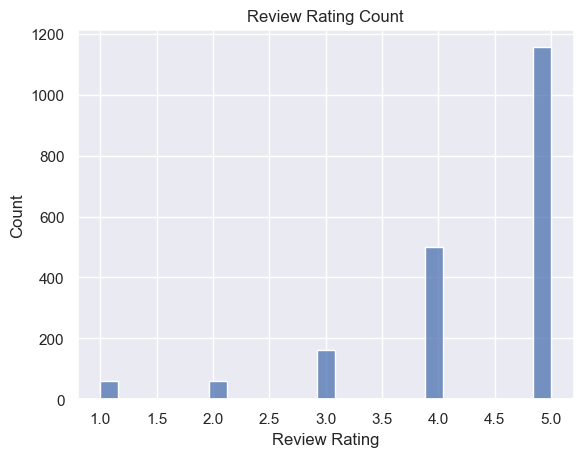

In [71]:
sns.histplot(data=reviews_df,
             x="review_rating")
plt.xlabel("Review Rating")
plt.ylabel("Count")
plt.title("Review Rating Count")
plt.savefig("./img/review_rating_hist.png")
plt.show()

Ok, looks like leaving a bad review is much rarer than leaving a good one.

One more thing that we can do that may be interesting is join the two dataframes, and see where the top reviewers relegated to one `city`, or did they review all over.

In [74]:
#merge df
merge_df=pd.merge(right=business_df, left=reviews_df,on="business_id")
merge_df.head()

,business_id,review_user_id,review_user,review_rating,review_text,name,address1,address2,city,postal_code,rating,review_count,is_cloused,latitude,longitude
0,AHB-e8F_dipajUaz_PJgDA,fGa2U9PDK2S32LcGsJNAyQ,Carol S.,5,Wow!! Krupa Grocery is an awesome brunch spot ...,Krupa Grocery,231 Prospect Park W,,Brooklyn,11215,4.5,390,False,40.659824,-73.980508
1,AHB-e8F_dipajUaz_PJgDA,RbwbMvXJ0_ZY1WmaaYKMrA,Nicole D.,5,The service was great. We got the barata as an...,Krupa Grocery,231 Prospect Park W,,Brooklyn,11215,4.5,390,False,40.659824,-73.980508
2,AHB-e8F_dipajUaz_PJgDA,8302qBEmZeTJZQY72xD4Sg,Lina F.,4,I love this place! It is my home away from hom...,Krupa Grocery,231 Prospect Park W,,Brooklyn,11215,4.5,390,False,40.659824,-73.980508
3,TQzGf4k3HXyMbnNkYKKQSw,jNKKoDWxBcSFRYNvA2hqBA,Maggie B.,5,I celebrated my partner's birthday here and it...,Oxalis,791 Washington Ave,None,Brooklyn,11238,4.5,242,False,40.673109,-73.962628
4,TQzGf4k3HXyMbnNkYKKQSw,CWtnLR7fF5jVukm5BvOzIg,Veronica J.,5,"If you want sublime dinner experience, Oxalis ...",Oxalis,791 Washington Ave,None,Brooklyn,11238,4.5,242,False,40.673109,-73.962628


In [79]:
# create top 10 reviewer list
top_10_reviewer_list = list(review_top10_df['review_user_id'])

In [82]:
# filter merged by top 10 list
filtered_df = merge_df[merge_df["review_user_id"].isin(top_10_reviewer_list)]

# preview
filtered_df.head()

,business_id,review_user_id,review_user,review_rating,review_text,name,address1,address2,city,postal_code,rating,review_count,is_cloused,latitude,longitude
154,GqzOGvwjduvXy3vZj_ChWw,VLTBPUrbNRR-f84h-altQw,Morlene C.,4,Israeli food is one of my favorites-- the fres...,Batata,3021 Fort Hamilton Pkwy,,Brooklyn,11218,4.0,214,False,40.648094,-73.979121
160,rU9cKxAVU4Gd_JhAqp_bTA,HVQKFDi-vZbawtmLMq3ZOw,Gab G.,5,Made a reservation for brunch for 4 people and...,Buttermilk Channel,524 Court St,,Brooklyn,11231,4.0,2037,False,40.675919,-73.999059
214,d9Z7lbeMV1ac591kAvJF5A,VU8_2JnGhK4fgCVS8MgofA,Robyn T.,5,Looking for the best BRUNCH spot ?? Look no fu...,ViaRoma,619 St Johns Pl,,Brooklyn,11238,4.5,36,False,40.672710,-73.957720
255,GyOMZgEV1mv0AI4FqWT8sQ,SqVUNVeYJblyoUz4e-Fiqw,Joseph T.,5,Welcoming cafe and restaurant. We were seated ...,Agi's Counter,818 Franklin Ave,,Brooklyn,11225,4.5,68,False,40.670000,-73.958370
267,XipQLDbyTl5tsLlyzAWzug,C75WezrbDZJusyJLX5a1Tw,Brianna B.,5,Nachos and tacos and margaritas...oh my! AND i...,Jajaja Mexicana,162 E Broadway,,New York,10002,4.5,1193,False,40.714190,-73.990410


Ok, now we can see if we have any city jumpers.

In [92]:
# view all columns
pd.set_option('display.max_colwidth',None)

# aggregate
filtered_df.groupby('review_user_id').agg(
    city_list=('city',list),
    name=('review_user','first'),
    review_count=('review_user_id','size')).sort_values(by='review_count',ascending=False)\
        .reset_index()

,review_user_id,city_list,name,review_count
0,CTAML26-nMaMRWyq4VrFsA,"[Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond]",Lena M.,9
1,jZoC7tuPaoEFduT8jUQnag,"[Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond, Richmond]",Casey S.,9
2,RLHvF8bRcnU4uEMohBvIow,"[Richmond, Richmond, Richmond, Richmond, Richmond, Richmond]",Leland L.,6
3,SqVUNVeYJblyoUz4e-Fiqw,"[Brooklyn, Brooklyn, Sunnyside, Middle Village, Forest Hills]",Joseph T.,5
4,VLTBPUrbNRR-f84h-altQw,"[Brooklyn, Brooklyn, Bronx, Brooklyn, New York]",Morlene C.,5
5,rKEtVvgJGL3mu2YYv6wF8w,"[Richmond, Richmond, Richmond, Richmond, Richmond]",Sharvani M.,5
6,C75WezrbDZJusyJLX5a1Tw,"[New York, New York, New York, New York]",Brianna B.,4
7,HVQKFDi-vZbawtmLMq3ZOw,"[Brooklyn, Astoria, Astoria, New York]",Gab G.,4
8,PD2ROaviFDsdg5ZaHFJF-g,"[Richmond, Richmond, Richmond, Richmond]",Jade H.,4
9,VU8_2JnGhK4fgCVS8MgofA,"[Brooklyn, Flushing, New York, New York]",Robyn T.,4


Let's visualize this as a heatmap.

In [122]:
# create df for each city by top 10 user'
occurrences_df = pd.get_dummies(
    filtered_df.explode('city')['city']
).groupby(filtered_df['review_user']).sum()


In [123]:
# sort by highest total occurrences
occurrences_df = occurrences_df[total_occurrences.sort_values(ascending=False).index]

# add a new column containing the sum of each row
occurrences_df['Total'] = occurrences_df.sum(axis=1)

# sort the DataFrame by the 'Total' column in descending order
occurrences_df = occurrences_df.sort_values(by='Total', ascending=False)

# drop the 'Total' row before plotting
occurrences_df = occurrences_df.drop('Total', axis=1)


In [124]:
occurrences_df

,Richmond,New York,Brooklyn,Astoria,Bronx,Flushing,Forest Hills,Middle Village,Sunnyside
review_user,,,,,,,,,
Casey S.,9,0,0,0,0,0,0,0,0
Lena M.,9,0,0,0,0,0,0,0,0
Leland L.,6,0,0,0,0,0,0,0,0
Joseph T.,0,0,2,0,0,0,1,1,1
Morlene C.,0,1,3,0,1,0,0,0,0
Sharvani M.,5,0,0,0,0,0,0,0,0
Brianna B.,0,4,0,0,0,0,0,0,0
Gab G.,0,1,1,2,0,0,0,0,0
Jade H.,4,0,0,0,0,0,0,0,0


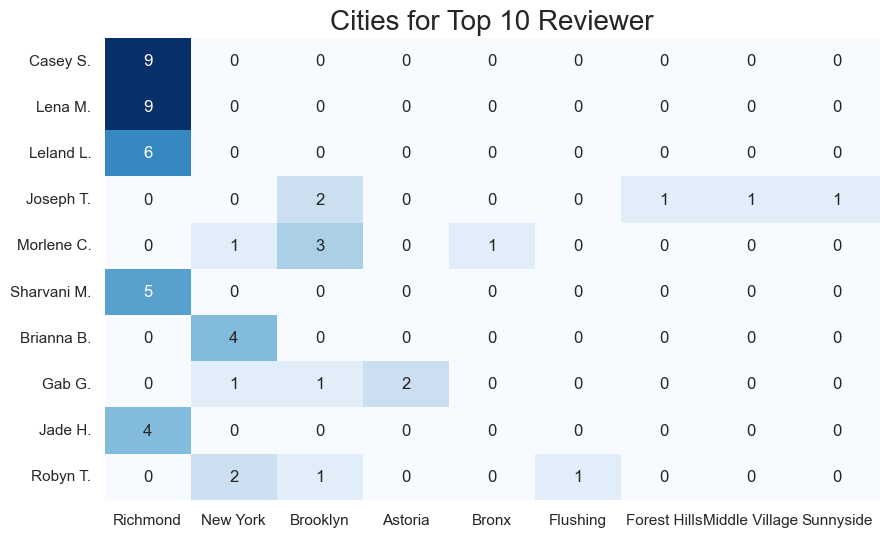

In [125]:

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(occurrences_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Cities for Top 10 Reviewer', fontdict={"fontsize":20})
plt.savefig("./img/heatmap_top10reviewers_city.png")
plt.show()

Looks like most of the 3 top reviewers are from `Richmond` County (Staten Island), and stick in one place. Once we get past the top 3, we see a bit more diversity in areas folks are reviewing.

## Data export
Pickle dataframes for future analysis with network graphing and text analysis.

In [32]:
business_df.to_pickle("./data/business_df_nyc_nyc.pkl")
review_df.to_pickle("./data/reviews_df_nyc.pkl")